In [1]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score

Using TensorFlow backend.


In [6]:
def lrcv(k, X, y):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    # Train a logistic regression for each fold
    aucs = []
    kappas = []
    # Calculate metrics for each affect
    for y_i in y.T:
        print('processing an affect')
        for train_index, test_index in skf.split(X, y_i):t
            print('processing a fold')
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_i[train_index], y_i[test_index]
            log_reg = LogisticRegression(max_iter=10000)
            log_reg.fit(X_train, y_train)
            y_pred = log_reg.predict(X_test)
            aucs.append(roc_auc_score(y_test, y_pred))
            kappas.append(cohen_kappa_score(y_test, np.around(y_pred)))
    return np.mean(fold_aucs), np.mean(fold_kappas)

In [3]:
input_data = pk.load(open('input_data.pkl', 'rb'))
target_data = pk.load(open('target_data.pkl', 'rb'))

pooling = []
dimention = []
auc = []
kappa = []

for pooling_name, pooling_function in zip(['Max Pooling', 'Mean Pooling'], [np.max, np.mean]):
    for dim in np.power(2, np.arange(12)):
        print(pooling_name, dim)
        aucs = []
        kappas = []
        for i in range(5):
            print('creating bag of random embeddings')
            random_embedding = (np.random.rand(input_data[0].shape[1], dim) * 2 - 1) * np.sqrt(input_data[0].shape[1])
            
            print('projecting input sequences')
            log_input = []
            for input_batch in input_data:
                embedded_input = np.dot(input_batch, random_embedding)
                embedded_input = pooling_function(embedded_input, axis=0)
                log_input.append(embedded_input)
            log_input = np.stack(log_input)
            
            # Get the average auc and kappa for all affects and folds
            mean_auc, mean_kappa = lrcv(5, log_input, np.array(target_data).astype(int))
            aucs.append(mean_auc)
            kappas.append(mean_kappa)
        pooling.append(pooling_name)
        dimention.append(dim)
        auc.append(np.mean(aucs))
        kappa.append(np.mean(kappas))

Max Pooling 1
creating bag of random embeddings
projecting input sequences
processing a fold
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing eac

processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
Max Pooling 64
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
pro

processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
Mean Pooling 1
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
proce

processing each affect
processing a fold
processing each affect
Mean Pooling 64
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
processing a fold
processing each affect
creating bag of random embeddings
projecting input sequences
processing a fold
processing each affect
processing a fold
pr

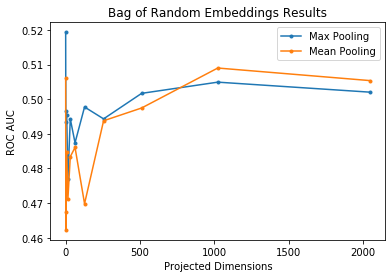

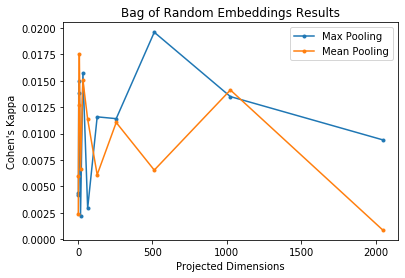

In [4]:
plt.figure()
plt.plot(dimention[:12], auc[:12], marker='.', label='Max Pooling')
plt.plot(dimention[12:], auc[12:], marker='.', label='Mean Pooling')
plt.xlabel('Projected Dimensions')
plt.ylabel('ROC AUC')
plt.title('Bag of Random Embeddings Results')
plt.legend()
plt.show()

plt.figure()
plt.plot(dimention[:12], kappa[:12], marker='.', label='Max Pooling')
plt.plot(dimention[12:], kappa[12:], marker='.', label='Mean Pooling')
plt.xlabel('Projected Dimensions')
plt.ylabel('Cohen\'s Kappa')
plt.title('Bag of Random Embeddings Results')
plt.legend()
plt.show()